# Estimating the Loss of Medieval Literature with an Unseen Species model from Ecodiversity

In [69]:
import numpy as np
np.random.seed(76451)
import scipy.stats as stats
from scipy.special import gammaln
import pandas as pd
import matplotlib.pyplot as plt
import ptitprince as pt
from functools import partial
import seaborn as sb
from tqdm import tqdm_notebook

## The loss of works

### Data

Read the data on Middle Dutch chivalric epics (*Middelnederlandse ridderepiek*), mainly drawn from Kienhorst's acclaimed 1988 repertory:

In [70]:
df = pd.read_excel('../data/mnl_chiv.xlsx', header=None)
df.columns = ('work', 'sigle', 'signature', 'fragmentary')
df.head()

,work,sigle,signature,fragmentary
0,Aiol (1),H1,"Leiden, UB, BPL 1049; Brussel, KB, IV 816",True
1,Aiol (2),H2,"Breda, Arch. Begijnhof, z.s.",True
2,Alexanders geesten,"München, Bayerische Staatsbibliotheek, Cod. ge...","München, Bayerische Staatsbibliotheek, Cod. ge...",False
3,Alexanders geesten,H3,"Gent, UB, 2749,6",True
4,Alexanders geesten,H4,"Leiden, UB, Ltk. 1196",True


Turn this tabular data into abundance data:

In [71]:
types = df.groupby('work').size().sort_values(ascending=False).value_counts().sort_index()
types = types.to_frame(name='Works')
types['Witnesses'] = types.index
types.loc['Total']  = (types['Works'].sum(), np.sum(types['Works'] * types['Witnesses']))
types

,Works,Witnesses
1,45,1
2,13,2
3,6,3
4,2,4
5,4,5
6,1,6
7,1,7
10,2,10
17,1,17
Total,75,167


In [72]:
print(types.to_latex(index=False, bold_rows=True))

\begin{tabular}{rr}
\toprule
 Works &  Witnesses \\
\midrule
    45 &          1 \\
    13 &          2 \\
     6 &          3 \\
     2 &          4 \\
     4 &          5 \\
     1 &          6 \\
     1 &          7 \\
     2 &         10 \\
     1 &         17 \\
    75 &        167 \\
\bottomrule
\end{tabular}



In [73]:
cnts = df.groupby('work').size().values # ignore zero
cnts

array([ 1,  1,  1,  5,  2,  1,  2,  1,  1,  3,  1,  1,  2,  1,  1,  2,  1,
        1,  1,  2,  1,  1,  1,  1,  1, 17,  1,  4,  1,  7,  1,  1,  1,  1,
        2, 10,  4,  1,  3,  1,  1,  1,  1,  1,  1,  1,  1,  6,  1,  2,  5,
        5,  3,  2,  3,  1,  1,  3, 10,  2,  5,  1,  2,  2,  1,  1,  2,  1,
        1,  2,  1,  1,  1,  1,  3])

### Estimators

#### Chao1

In [74]:
def chao_richness(x):
    x, n = x[x > 0], x.sum()
    t = x.shape[0]
    f1, f2 = (x == 1).sum(), (x == 2).sum()
    return t + (n - 1) / n * ((f1 ** 2 / 2 / f2) if f2 > 0 else (f1 * (f1 - 1) / 2))

In [75]:
chao_richness(cnts)

152.41824044219254

In [76]:
def bt_prob(x):
    x, n = x[x > 0], x.sum()
    f1, f2 = (x == 1).sum(), (x == 2).sum()
    C = 1 - f1 / n * (((n - 1) * f1 / ((n - 1) * f1 + 2 * f2)) if f2 > 0 else
                      ((n - 1) * (f1 - 1) / ((n - 1) * (f1 - 1) + 2)) if f1 > 0 else
                      0)
    W = (1 - C) / np.sum(x / n * (1 - x / n) ** n)
    p = x / n * (1 - W * (1 - x / n) ** n)
    f0 = np.ceil(((n - 1) / n * f1 ** 2 / (2 * f2)) if f2 > 0 else
                 ((n - 1) / n * f1 * (f1 - 1) / 2))
    p0 = (1 - C) / f0
    p = np.hstack((p, np.array([p0 for i in np.arange(f0)])))
    return p


def bootstrap(x, fn=chao_richness, n_iter=1000, conf=.95):
    # define a multinomial probability distribution
    # for the bootstrap procedure to sample from:
    p, n = bt_prob(x), x.sum()
    data_bt = np.random.multinomial(n, p, n_iter)
    
    pro = np.array([fn(row) for row in data_bt])
    
    pro_mean = pro.mean(0)
    
    lci_pro = -np.quantile(pro, (1 - conf) / 2, axis=0) + pro_mean
    uci_pro = np.quantile(pro, 1 - (1 - conf) / 2, axis=0) - pro_mean

    sd_pro = np.std(pro, axis=0)

    pro = pro_mean - pro
    return (lci_pro, uci_pro, sd_pro, pro)

In [77]:
def chao_estimate(x, n_iter=10000, conf=0.95):
    pro = chao_richness(x)
    (lci_pro, uci_pro, sd_pro, bt_pro) = bootstrap(x, fn=chao_richness, n_iter=n_iter, conf=conf)
    lci_pro, uci_pro = pro - lci_pro, pro + uci_pro
    bt_pro = pro - bt_pro
    return (lci_pro, uci_pro, bt_pro, pro)

In [78]:
lci_pro, uci_pro, chao1_pro, pro = chao_estimate(cnts)
print(f'Chao1: {pro:.2f} CI({lci_pro:.2f} - {uci_pro:.2f})')

Chao1: 152.42 CI(110.46 - 225.73)


#### Jackknife

In [79]:
def dbinom(x, size, prob):
    d = stats.binom(size, prob).pmf(x)
    return 1 if np.isnan(d) else d


def jackknife(data, k=5, conf=0.95):
    k0, k = k, min(len(np.unique(data)) - 1, 10)
    n = np.bincount(data)[1:]
    n = np.array((np.arange(1, n.shape[0] + 1), n)).T
    total = n[:, 1].sum()
    gene = np.zeros((k + 1, 5))
    gene[0, 0] = total
    for i in range(1, k + 1):
        gene[i, 0] = total
        gene[i, 3] = total
        for j in range(1, i + 1):
            gene[i, 0] = (
                gene[i, 0] +
                (-1)**(j + 1) * 2**i * dbinom(j, i, 0.5) * n[j - 1, 1])
            gene[i, 3] = gene[i, 3] + (-1)**(j + 1) * 2**i * dbinom(
                j, i, 0.5) * n[j - 1, 1] * np.prod(np.arange(1, j + 1))
        gene[i, 1] = -gene[i, 0]
        for j in range(1, i + 1):
            gene[i, 1] = (gene[i, 1] + (
                (-1)**(j + 1) * 2**i * dbinom(j, i, 0.5) + 1)**2 * n[j - 1, 1])
        gene[i, 1] = np.sqrt(gene[i, 1] + n[i:, 1].sum())
    if k > 1:
        for i in range(2, k + 1):
            gene[i - 1, 2] = -(gene[i, 0] - gene[i - 1, 0])**2 / (total - 1)
            for j in range(1, i):
                gene[i - 1, 2] = gene[i - 1, 2] + (
                    (-1)**(j + 1) * 2**(i) * dbinom(j, i, 0.5) -
                    (-1)**(j + 1) * 2**(i - 1) * dbinom(j, i - 1, 0.5)
                )**2 * n[j - 1, 1] * total / (total - 1)
            gene[i - 1, 2] = np.sqrt(gene[i - 1, 2] + n[i - 1, 1] * total /
                                     (total - 1))
            gene[i - 1, 4] = (gene[i, 0] - gene[i - 1, 0]) / gene[i - 1, 2]
    coe = stats.norm().ppf(1 - (1 - 0.95) / 2)
    x = gene[1:k + 1, 4] < coe
    if x.sum() == 0:
        jackest = gene[k, 0]
        sej = gene[k, 1]
        order = 1
    else:
        indicator = np.arange(1, k + 1)
        jackest = gene[indicator[x][0], 0]
        sej = gene[indicator[x][0], 1]
        order = np.arange(1, k + 2)[indicator[x][0]] - 1
    if k0 <= order:
        jackest = gene[k0, 0]
        sej = gene[k0, 1]
        order = k0
    return jackest, sej, order, jackest - coe * sej, jackest + coe * sej

In [80]:
jk, sej, order, jk_lci, jk_uci = jackknife(cnts)
print(f'Jackknife (@order={order}): {jk:.2f} CI({jk_lci:.2f} - {jk_uci:.2f})')

Jackknife (@order=3): 177.00 CI(127.81 - 226.19)


#### Egghe & Proot

In [81]:
def ep(counts, alpha=500):
    ft = np.bincount(counts)[1:]
    S = ft.sum()
    P1, P2 = (counts == 1).sum(), (counts == 2).sum()
    P0 = (1 / (1 + (2 / (alpha - 1)) * (P2 / P1))) ** alpha
    S_lost = S * (P0 / (1 - P0))
    S_lost = S + S_lost
    return S_lost if not np.isinf(S_lost) else np.nan

In [82]:
ep_score = ep(cnts)

In [83]:
def ep_estimate(x, n_iter=10000, conf=0.95):
    pro = ep(x)
    (lci_pro, uci_pro, sd_pro, bt_pro) = bootstrap(x, fn=ep, n_iter=n_iter, conf=conf)
    lci_pro, uci_pro = pro - lci_pro, pro + uci_pro
    bt_pro = pro - bt_pro
    return (lci_pro, uci_pro, bt_pro, pro)

In [84]:
lci_pro, uci_pro, ep_pro, pro = ep_estimate(cnts)
print(f'Egghe & Proot: {pro:.2f} CI({lci_pro:.2f} - {uci_pro:.2f})')

Egghe & Proot: 170.72 CI(115.35 - 273.76)


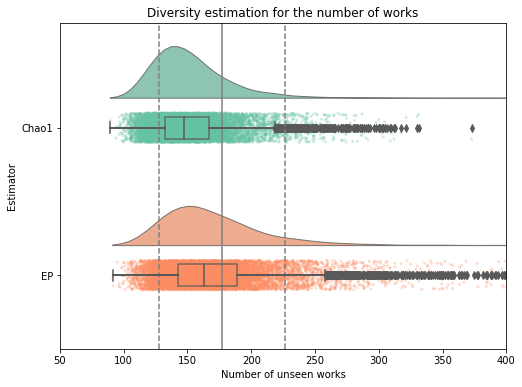

In [98]:
d = list([(x, 'Chao1') for x in chao1_pro])
d += list([(x, 'EP') for x in ep_pro])
bt = pd.DataFrame(d, columns=('bootstrap', 'Estimator'))
bt

fig, ax = plt.subplots(figsize=(8, 6))
pt.RainCloud(
    data=bt, x="Estimator", y="bootstrap", ax=ax, 
    orient="h", alpha=.8, bw=.2, rain_alpha=.3,
);

ax.axvline(jk, c='grey')
ax.axvline(jk_lci, c='grey', ls='--')
ax.axvline(jk_uci, c='grey', ls='--')
ax.set_xlabel('Number of unseen works')

ax.set_xlim([50, 400])
plt.title('Diversity estimation for the number of works');

## The loss of documents

### Maculature

Our data indicate whether a witness has survived fragmentarily (as "maculature") or not. In the former case, remnants of the very  same source have sometimes emerged in different locales. These can also be treated as different sightings of a manuscript, which allows us to estimate (a lower bound for) the total number of manuscripts that were once cut up to be recycled. (Note that this is a different number from the total population size of Middle Dutch manuscripts in this genre.)

In [99]:
mss_cnts = []
for sign, fragm in zip(df['signature'], df['fragmentary']):
    if fragm: # we ignore witnesses that survived in full
        try:
            mss_cnts.append(len(sign.split(';')))
        except AttributeError:
            pass
mss_cnts = np.array(mss_cnts)

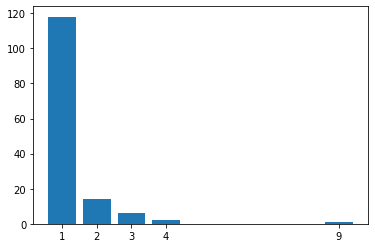

In [100]:
labels, counts = np.unique(mss_cnts, return_counts=True)
plt.bar(labels, counts, align='center')
plt.gca().set_xticks(labels);

In [101]:
x = mss_cnts
x, n = x[x > 0], x.sum()
t = x.shape[0]
f1, f2 = (x == 1).sum(), (x == 2).sum()
print('number of fragments:', n)
print('number of documents:', t)
print('f1:', f1)
print('f2:', f2)

number of fragments: 181
number of documents: 141
f1: 118
f2: 14


In [102]:
mac_lci_pro, mac_uci_pro, mac_chao1_pro, mac_pro = chao_estimate(mss_cnts)
print(f'Chao1 (maculature): {mac_pro:.2f} CI({mac_lci_pro:.2f} - {mac_uci_pro:.2f})')

Chao1 (maculature): 635.54 CI(447.83 - 957.99)


### Minimum sampling

In [103]:
def minsample(x):
    n = x.sum()
    x = x[x > 0]
    t = x.shape[0]
    f1, f2 = (x == 1).sum(), (x == 2).sum()
    h = lambda x: 2 * f1 * (1 + x)
    v = lambda x: np.exp(x * (2 * f2 / f1))
    
    search_space = np.linspace(0, 100, 10000)
    hs = np.array(h(search_space))
    vs = np.array(v(search_space))
    diffs = np.abs(hs - vs)
    x_ast = search_space[diffs.argmin()]
    return n * x_ast

In [104]:
ms = minsample(cnts)
print('Estimate:', 100 / (minsample(cnts) / cnts.sum()), '% of documents survived')

Estimate: 8.1557911908646 % of documents survived


In [105]:
def minsample_estimate(x, n_iter=10000, conf=0.95):
    pro = minsample(x)
    (lci_pro, uci_pro, sd_pro, bt_pro) = bootstrap(x, fn=minsample, n_iter=n_iter, conf=conf)
    lci_pro, uci_pro = pro - lci_pro, pro + uci_pro
    bt_pro = pro - bt_pro
    return (lci_pro, uci_pro, bt_pro, pro)

In [106]:
lci, uci, bt_msample, ms = minsample_estimate(cnts)
print(f'Minimum sampling: {ms:.2f} CI({lci:.2f} - {uci:.2f})')

Minimum sampling: 2047.62 CI(1060.26 - 4018.13)


## Species Accumulation curve, with miminum sampling effort included

In [107]:
def bootstrap_re(x, fn=chao_richness, n_iter=1000, conf=.95):
    # define a multinomial probability distribution
    # for the bootstrap procedure to sample from:
    p, n = bt_prob(x), x.sum()
    data_bt = np.random.multinomial(n, p, n_iter)
    
    Dq = fn(x)
    
    pro = np.array([fn(row) for row in data_bt])
    
    error = stats.norm.ppf(1 - (1 - conf) / 2) * np.std(pro, 0)
    lci_pro = Dq - error
    uci_pro = Dq + error

    sd_pro = np.std(pro, axis=0)

    return (lci_pro, uci_pro, sd_pro, Dq, )


def rarefaction_extrapolation(x, max_steps):
    x, n = x[x > 0], x.sum()
    def _sub(m):
        if m <= n:
            return np.sum(1 - np.array(
                [np.exp(gammaln(n - i + 1) + gammaln(n - m + 1) - 
                        gammaln(n - i - m + 1) - gammaln(n + 1)) if i <= (n - m) else
                 0 for i in x]))
        else:
            S = (x > 0).sum()
            f1, f2 = (x == 1).sum(), (x == 2).sum()
            f0 = ((n - 1) / n * f1 * (f1 - 1) / 2) if f2 == 0 else ((n - 1) / n * f1**2 / 2 / f2)
            A = n * f0 / (n * f0 + f1)
            return S if f1 == 0 else (S + f0 * (1 - A**(m - n)))
    return np.array([_sub(mi) for mi in range(1, max_steps)])

In [108]:
num_docs = len(cnts) + int(minsample(cnts)) # n + m
lci_pro, uci_pro, sd_pro, Dq = bootstrap_re(cnts, fn=partial(rarefaction_extrapolation, max_steps=num_docs),
                                            n_iter=100)

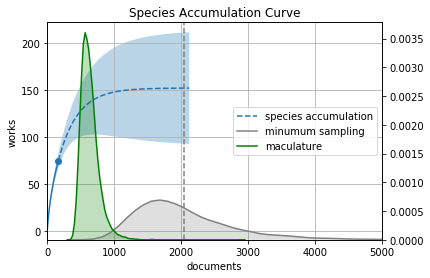

In [109]:
steps = np.arange(1, num_docs)
interpolated = np.arange(1, num_docs) < cnts.sum()
figure = plt.Figure(figsize=(8, 6))
plt.plot(steps[interpolated], Dq[interpolated], color='C0')
plt.plot(cnts.sum(), Dq[cnts.sum() - 1], 'o')
plt.plot(steps[~interpolated], Dq[~interpolated], '--', color='C0')
plt.fill_between(steps, lci_pro, uci_pro, alpha=0.3)
plt.grid()
plt.axvline(ms, ls='--', c='grey')
plt.xlabel('documents')
plt.ylabel('works')
plt.title('Species Accumulation Curve')
ax2 = plt.gca().twinx()
ax2.plot(np.nan, '--', color='C0', label='species accumulation')
sb.kdeplot(bt_msample, ax=ax2, color='grey', shade=True, label='minumum sampling')
sb.kdeplot(mac_chao1_pro, ax=ax2, color='green', shade=True, label='maculature')
ax2.legend(loc='center right')
plt.xlim([0, 5000]);

## Simulations

In the seminal paper on Malaysian butterflies, R.A. Fischer proposed the logseries model to capture the relative abundance of species in an assemblage. The logseries predicts the number of species at different levels of abundance ($n$ individuals) with the formula:

\begin{equation*}
S_n = \alpha x^n / n
\end{equation*}

In [110]:
def fisher_richness(idx, alpha, x_):
    return (alpha * (x_ ** idx)) / idx

Here, $S_n$ is the number of species with an abundance of $n$; $x$ = a positive constant ($0 < x < 1$) which is derived from the sample data set but generally approaches 1; $\alpha$ finally is the number of singleton species in the assemblage. We can fit this model to the Middle Dutch data (that seems to follow a surprisingly similar distribution):

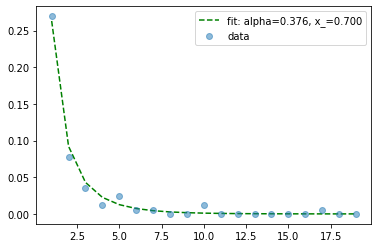

In [111]:
counts = df.groupby('work').size().sort_values(ascending=False).values
n_s = np.array(list(range(1, 20)))
abundance = np.array([np.sum(counts == i)/np.sum(counts) for i in n_s])
import scipy.optimize as optim
popt, pcov = optim.curve_fit(fisher_richness, xdata=n_s, ydata=abundance,
                             bounds=([0, 0.7], [100, 1.05]))
plt.plot(n_s, fisher_richness(n_s, *popt), 'g--',
         label='fit: alpha=%5.3f, x_=%5.3f' % tuple(popt))
plt.plot(n_s, abundance, 'o', label='data', alpha=0.5);
plt.legend();

Fisher's logseries can be used to define a discrete probability distribution, parametrized by two values:
 - the number of singleton species in the population
 - the maximum number of attestations for a single species (to put a practical cap on the distribution)

If we sample $num\_species$ species from this probability distribution, we can simulate virtual assemblages that mimic the properties of the observed data.

In [112]:
def fisher_pop(n, alpha=0.9, x=5, num_species=600):
    """
    alpha = number of singleton species (f1)
    n = max attestation frequency of a particular species
    x = constant [0, 1], approx. 1
    """
    orders = np.array([fisher_richness(i, alpha, x) for i in range(1, n + 1)])
    props = orders / orders.sum()
    assemblage = []
    elements = [i + 1 for i in np.arange(n)]
    for idx, sample in enumerate(np.random.choice(elements, num_species + 1, p=props)):
        assemblage.extend(sample * [idx])
    return np.array(assemblage)

assemblage = fisher_pop(n=50, alpha=75, x=.99, num_species=250)
assemblage

array([  0,   0,   0, ..., 250, 250, 250])

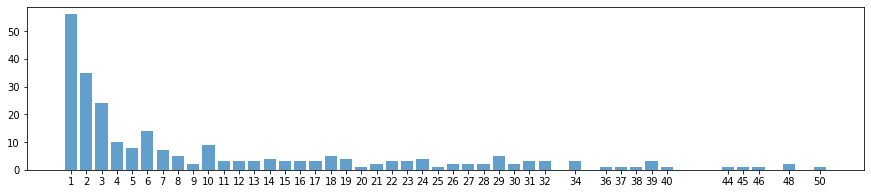

In [113]:
plt.figure(figsize=(15, 3))
abundance_cnt = np.bincount(assemblage)[1:]
labels, counts = np.unique(abundance_cnt, return_counts=True)
plt.bar(labels, counts, align='center', alpha=0.7)
plt.gca().set_xticks(labels);

The original species in the simulated assemblage:

In [114]:
print('# works:',  len(abundance_cnt))
print('# documents:', abundance_cnt.sum())
print('# singletons:', abundance_cnt[abundance_cnt == 1].sum(),
      f'({abundance_cnt[abundance_cnt == 1].sum()/len(abundance_cnt) * 100 :.2f}%)')

# works: 250
# documents: 2558
# singletons: 56 (22.40%)


Next, we can stochastically sample (at certain "keep rates") from this population to simulate the historic loss of documents.

In [115]:
def loss(assemblage_, keep_rate):
    assemblage_ = list(assemblage_)
    np.random.shuffle(assemblage_)
    retrieved = assemblage_[:int(len(assemblage_) * keep_rate)]
    return np.array(retrieved)

retrieved = loss(assemblage, keep_rate=0.20)

Let us check what this sampling did to our statistics:

In [116]:
_, impaired_counts = np.unique(retrieved, return_counts=True)
print('Impaired population:')
print('# works:',  len(impaired_counts))
print('# documents:', impaired_counts.sum())
print('# singletons:', impaired_counts[impaired_counts == 1].sum(),
      f'({impaired_counts[impaired_counts == 1].sum()/len(impaired_counts) * 100:.2f}%)')

Impaired population:
# works: 158
# documents: 513
# singletons: 52 (32.91%)


This makes sense (as is also illustrated in the plot below): the number of documents goes down by a factor of the keep rate and inevitably we lose some works, but not at the same rate (we primarily lose those that existed in low abundance in the original population). Perhaps counterintuitively, this also implies that the number of singletons should proportionally go up in the impaired sample.

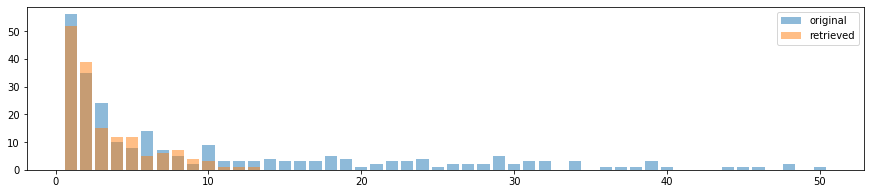

In [117]:
plt.figure(figsize=(15, 3))
abundance_cnt = np.bincount(assemblage)[1:]
labels, counts = np.unique(abundance_cnt, return_counts=True)
plt.bar(labels, counts, align='center', alpha=0.5, label='original')

impaired_labels_, impaired_counts_ = np.unique(impaired_counts, return_counts=True)
plt.bar(impaired_labels_, impaired_counts_, align='center', alpha=0.5, label='retrieved')
plt.legend();

In [118]:
print(chao_richness(impaired_counts))
print(jackknife(impaired_counts)[0])
print(ep(impaired_counts))

192.59909031838856
210.0
203.3364003871593


### Loss of works

In [119]:
from tqdm import tqdm

def rmse(pred, true):
    return np.sqrt((pred - true) ** 2)

def e(pred, true):
    return pred - true

num_documents = np.arange(500, 2500, 100)
keep_rates = np.linspace(0.05, 0.95, len(num_documents))
n_experiments = 10

num_works = 250
f1 = 75
x = .99

In [120]:
results, doc_results = [], []
for i, num_doc in enumerate(tqdm(num_documents)):
    for kr in keep_rates: 
        for j in range(n_experiments):
            assemblage = fisher_pop(n=num_doc, alpha=f1, x=x, num_species=num_works)
            retrieved = loss(assemblage, keep_rate=kr)
            _, impaired_counts = np.unique(retrieved, return_counts=True)
            results.append({'keep rate': kr, 'estimator': 'Egghe & Proot',
                            'diversity': ep(impaired_counts, alpha=50),
                            'num_documents': num_doc})
            results.append({'keep rate': kr, 'estimator': 'Jackknife',
                            'diversity': jackknife(impaired_counts)[0],
                            'num_documents': num_doc})
            results.append({'keep rate': kr, 'estimator': 'Chao1',
                            'diversity': chao_richness(impaired_counts),
                            'num_documents': i})
            doc_results.append({'keep rate': kr, 'diversity': minsample(impaired_counts),
                               'num_documents': num_doc})

S_df = pd.DataFrame(results)
D_df = pd.DataFrame(doc_results)

  0%|          | 0/20 [00:17<?, ?it/s]


KeyboardInterrupt: 

In [42]:
S_df['Error'] = S_df['diversity'] - num_works
S_df['AbsError'] = np.abs(S_df['Error'])

In [43]:
S_df.head(10)

,keep rate,estimator,diversity,num_documents,Error,AbsError
0,0.05,Egghe & Proot,139.974451,500,-110.025549,110.025549
1,0.05,Jackknife,152.000000,500,-98.000000,98.000000
2,0.05,Chao1,130.800000,0,-119.200000,119.200000
3,0.05,Egghe & Proot,145.352745,500,-104.647255,104.647255
4,0.05,Jackknife,154.000000,500,-96.000000,96.000000
5,0.05,Chao1,132.954665,0,-117.045335,117.045335
6,0.05,Egghe & Proot,126.373467,500,-123.626533,123.626533
7,0.05,Jackknife,134.000000,500,-116.000000,116.000000
8,0.05,Chao1,123.049793,0,-126.950207,126.950207
9,0.05,Egghe & Proot,156.859811,500,-93.140189,93.140189


In [44]:
D_df['Error'] = D_df['diversity'] - D_df['num_documents']
D_df['AbsError'] = np.abs(D_df['Error'])
D_df.head(10)

,keep rate,diversity,num_documents,Error,AbsError
0,0.05,1352.535254,500,852.535254,852.535254
1,0.05,1634.293429,500,1134.293429,1134.293429
2,0.05,1050.865087,500,550.865087,550.865087
3,0.05,1638.883888,500,1138.883888,1138.883888
4,0.05,1603.960396,500,1103.960396,1103.960396
5,0.05,2916.291629,500,2416.291629,2416.291629
6,0.05,2020.952095,500,1520.952095,1520.952095
7,0.05,1996.599660,500,1496.599660,1496.599660
8,0.05,2757.535754,500,2257.535754,2257.535754
9,0.05,2286.948695,500,1786.948695,1786.948695


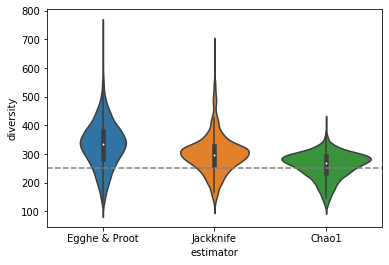

In [45]:
ax = sb.violinplot(x="estimator", y="diversity", data=S_df)
ax.axhline(num_works, ls='--', c='grey')

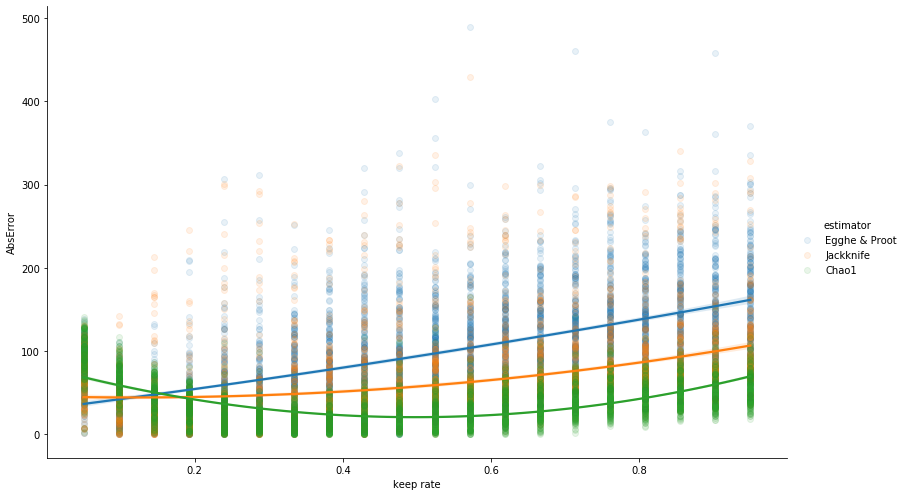

In [46]:
g = sb.lmplot(x="keep rate", y="AbsError", hue="estimator", order=2,
              ci=95, data=S_df, scatter_kws={'alpha':0.1}, height=7, aspect=1.6)